# Machine Learning Trading Bot

In this Challenge, you’ll assume the role of a financial advisor at one of the top five financial advisory firms in the world. Your firm constantly competes with the other major firms to manage and automatically trade assets in a highly dynamic environment. In recent years, your firm has heavily profited by using computer algorithms that can buy and sell faster than human traders.

The speed of these transactions gave your firm a competitive advantage early on. But, people still need to specifically program these systems, which limits their ability to adapt to new data. You’re thus planning to improve the existing algorithmic trading systems and maintain the firm’s competitive advantage in the market. To do so, you’ll enhance the existing trading signals with machine learning algorithms that can adapt to new data.

## Instructions:

Use the starter code file to complete the steps that the instructions outline. The steps for this Challenge are divided into the following sections:

* Establish a Baseline Performance

* Tune the Baseline Trading Algorithm

* Evaluate a New Machine Learning Classifier

* Create an Evaluation Report

#### Establish a Baseline Performance

In this section, you’ll run the provided starter code to establish a baseline performance for the trading algorithm. To do so, complete the following steps.

Open the Jupyter notebook. Restart the kernel, run the provided cells that correspond with the first three steps, and then proceed to step four. 

1. Import the OHLCV dataset into a Pandas DataFrame.

2. Generate trading signals using short- and long-window SMA values. 

3. Split the data into training and testing datasets.

4. Use the `SVC` classifier model from SKLearn's support vector machine (SVM) learning method to fit the training data and make predictions based on the testing data. Review the predictions.

5. Review the classification report associated with the `SVC` model predictions. 

6. Create a predictions DataFrame that contains columns for “Predicted” values, “Actual Returns”, and “Strategy Returns”.

7. Create a cumulative return plot that shows the actual returns vs. the strategy returns. Save a PNG image of this plot. This will serve as a baseline against which to compare the effects of tuning the trading algorithm.

8. Write your conclusions about the performance of the baseline trading algorithm in the `README.md` file that’s associated with your GitHub repository. Support your findings by using the PNG image that you saved in the previous step.

#### Tune the Baseline Trading Algorithm

In this section, you’ll tune, or adjust, the model’s input features to find the parameters that result in the best trading outcomes. (You’ll choose the best by comparing the cumulative products of the strategy returns.) To do so, complete the following steps:

1. Tune the training algorithm by adjusting the size of the training dataset. To do so, slice your data into different periods. Rerun the notebook with the updated parameters, and record the results in your `README.md` file. Answer the following question: What impact resulted from increasing or decreasing the training window?

> **Hint** To adjust the size of the training dataset, you can use a different `DateOffset` value&mdash;for example, six months. Be aware that changing the size of the training dataset also affects the size of the testing dataset.

2. Tune the trading algorithm by adjusting the SMA input features. Adjust one or both of the windows for the algorithm. Rerun the notebook with the updated parameters, and record the results in your `README.md` file. Answer the following question: What impact resulted from increasing or decreasing either or both of the SMA windows?

3. Choose the set of parameters that best improved the trading algorithm returns. Save a PNG image of the cumulative product of the actual returns vs. the strategy returns, and document your conclusion in your `README.md` file.

#### Evaluate a New Machine Learning Classifier

In this section, you’ll use the original parameters that the starter code provided. But, you’ll apply them to the performance of a second machine learning model. To do so, complete the following steps:

1. Import a new classifier, such as `AdaBoost`, `DecisionTreeClassifier`, or `LogisticRegression`. (For the full list of classifiers, refer to the [Supervised learning page](https://scikit-learn.org/stable/supervised_learning.html) in the scikit-learn documentation.)

2. Using the original training data as the baseline model, fit another model with the new classifier.

3. Backtest the new model to evaluate its performance. Save a PNG image of the cumulative product of the actual returns vs. the strategy returns for this updated trading algorithm, and write your conclusions in your `README.md` file. Answer the following questions: Did this new model perform better or worse than the provided baseline model? Did this new model perform better or worse than your tuned trading algorithm?

#### Create an Evaluation Report

In the previous sections, you updated your `README.md` file with your conclusions. To accomplish this section, you need to add a summary evaluation report at the end of the `README.md` file. For this report, express your final conclusions and analysis. Support your findings by using the PNG images that you created.


In [74]:
# Imports
import pandas as pd
import numpy as np
from pathlib import Path
import hvplot.pandas
import matplotlib.pyplot as plt
from sklearn import svm                                 #  support vector machine (SVM) learning method
from sklearn.preprocessing import StandardScaler
from pandas.tseries.offsets import DateOffset
from sklearn.metrics import classification_report

from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier, NearestNeighbors, kneighbors_graph
from sklearn.metrics import confusion_matrix
from sklearn.metrics import balanced_accuracy_score
from imblearn.metrics import classification_report_imbalanced
from sklearn.metrics import f1_score

import hvplot.pandas
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

---

## Establish a Baseline Performance

In this section, you’ll run the provided starter code to establish a baseline performance for the trading algorithm. To do so, complete the following steps.

Open the Jupyter notebook. Restart the kernel, run the provided cells that correspond with the first three steps, and then proceed to step four. 


### Step 1: import the OHLCV dataset into a Pandas DataFrame.

In [2]:
# Import the OHLCV dataset into a Pandas Dataframe
ohlcv_df = pd.read_csv(
    Path('./Resources/emerging_markets_ohlcv.csv'), 
    index_col='date', 
    infer_datetime_format=True, 
    parse_dates=True
)

# Review the DataFrame
display(ohlcv_df.shape)
display(ohlcv_df.head(3))

(4323, 5)

,open,high,low,close,volume
date,,,,,
2015-01-21 09:30:00,23.83,23.83,23.83,23.83,100
2015-01-21 11:00:00,23.98,23.98,23.98,23.98,100
2015-01-22 15:00:00,24.42,24.42,24.42,24.42,100


In [3]:
# Filter the date index and close columns
signals_df = ohlcv_df.loc[:, ['close']]

# Use the pct_change function to generate  returns from close prices
signals_df['Actual Returns'] = signals_df['close'].pct_change()

# Drop all NaN values from the DataFrame
signals_df = signals_df.dropna()

# Review the DataFrame
display(signals_df.head(3))
display(signals_df.tail(3))

,close,Actual Returns
date,,
2015-01-21 11:00:00,23.98,0.006295
2015-01-22 15:00:00,24.42,0.018349
2015-01-22 15:15:00,24.44,0.000819


,close,Actual Returns
date,,
2021-01-22 13:45:00,33.42,0.002099
2021-01-22 14:30:00,33.47,0.001496
2021-01-22 15:45:00,33.44,-0.000896


## Step 2: Generate trading signals using short- and long-window SMA values. 

In [4]:
# Set the short window and long window
short_window = 4
long_window = 100

# Generate the fast and slow simple moving averages (4 and 100 days, respectively)
signals_df['SMA_Fast'] = signals_df['close'].rolling(window=short_window).mean()
signals_df['SMA_Slow'] = signals_df['close'].rolling(window=long_window).mean()

signals_df = signals_df.dropna()

# Review the DataFrame
display(signals_df.head(3))
display(signals_df.tail(3))

,close,Actual Returns,SMA_Fast,SMA_Slow
date,,,,
2015-04-02 14:45:00,24.92,0.000000,24.9175,24.3214
2015-04-02 15:00:00,24.92,0.000000,24.9200,24.3308
2015-04-02 15:15:00,24.94,0.000803,24.9250,24.3360


,close,Actual Returns,SMA_Fast,SMA_Slow
date,,,,
2021-01-22 13:45:00,33.42,0.002099,33.3850,30.48745
2021-01-22 14:30:00,33.47,0.001496,33.3775,30.53085
2021-01-22 15:45:00,33.44,-0.000896,33.4200,30.57495


In [5]:
# Initialize the new Signal column
signals_df['Signal'] = 0.0

# When Actual Returns are greater than or equal to 0, generate signal to buy stock long
signals_df.loc[(signals_df['Actual Returns'] >= 0), 'Signal'] = 1

# When Actual Returns are less than 0, generate signal to sell stock short
signals_df.loc[(signals_df['Actual Returns'] < 0), 'Signal'] = -1

# Review the DataFrame
display(signals_df.head(3))
display(signals_df.tail(3))

,close,Actual Returns,SMA_Fast,SMA_Slow,Signal
date,,,,,
2015-04-02 14:45:00,24.92,0.000000,24.9175,24.3214,1.0
2015-04-02 15:00:00,24.92,0.000000,24.9200,24.3308,1.0
2015-04-02 15:15:00,24.94,0.000803,24.9250,24.3360,1.0


,close,Actual Returns,SMA_Fast,SMA_Slow,Signal
date,,,,,
2021-01-22 13:45:00,33.42,0.002099,33.3850,30.48745,1.0
2021-01-22 14:30:00,33.47,0.001496,33.3775,30.53085,1.0
2021-01-22 15:45:00,33.44,-0.000896,33.4200,30.57495,-1.0


In [6]:
signals_df['Signal'].value_counts()

 1.0    2368
-1.0    1855
Name: Signal, dtype: int64

In [7]:
# Calculate the strategy returns and add them to the signals_df DataFrame
signals_df['Strategy Returns'] = signals_df['Actual Returns'] * signals_df['Signal'].shift()

# Review the DataFrame
display(signals_df.head(3))
display(signals_df.tail(3))

,close,Actual Returns,SMA_Fast,SMA_Slow,Signal,Strategy Returns
date,,,,,,
2015-04-02 14:45:00,24.92,0.000000,24.9175,24.3214,1.0,NaN
2015-04-02 15:00:00,24.92,0.000000,24.9200,24.3308,1.0,0.000000
2015-04-02 15:15:00,24.94,0.000803,24.9250,24.3360,1.0,0.000803


,close,Actual Returns,SMA_Fast,SMA_Slow,Signal,Strategy Returns
date,,,,,,
2021-01-22 13:45:00,33.42,0.002099,33.3850,30.48745,1.0,0.002099
2021-01-22 14:30:00,33.47,0.001496,33.3775,30.53085,1.0,0.001496
2021-01-22 15:45:00,33.44,-0.000896,33.4200,30.57495,-1.0,-0.000896


In [8]:
# Plot Strategy Returns to examine performance
(1 + signals_df['Strategy Returns']).cumprod().hvplot()

:Curve   [date]   (Strategy Returns)

### Step 3: Split the data into training and testing datasets.

In [9]:
# Assign a copy of the sma_fast and sma_slow columns to a features DataFrame called X
X = signals_df[['SMA_Fast', 'SMA_Slow']].shift().dropna()

# Review the DataFrame
X.head(3)

,SMA_Fast,SMA_Slow
date,,
2015-04-02 15:00:00,24.9175,24.3214
2015-04-02 15:15:00,24.9200,24.3308
2015-04-02 15:30:00,24.9250,24.3360


In [10]:
# Alternate features set split
# Assign a copy of the sma_fast and sma_slow columns to a features DataFrame called X
Xa = signals_df[['SMA_Fast', 'SMA_Slow']].shift().dropna()

# Review the DataFrame
Xa.head(3)

,SMA_Fast,SMA_Slow
date,,
2015-04-02 15:00:00,24.9175,24.3214
2015-04-02 15:15:00,24.9200,24.3308
2015-04-02 15:30:00,24.9250,24.3360


In [11]:
# plot features
X.hvplot()

:NdOverlay   [Variable]
   :Curve   [date]   (value)

In [12]:
# Create the target set selecting the Signal column and assiging it to y
y = signals_df['Signal']

# Review the value counts
display(y.shape)
display(y.value_counts())

(4223,)

 1.0    2368
-1.0    1855
Name: Signal, dtype: int64

In [13]:
# Alternate target set split
# Create the target set selecting the Signal column and assiging it to y
ya = signals_df['Signal']

# Review the value counts
display(ya.shape)
display(ya.value_counts())

(4223,)

 1.0    2368
-1.0    1855
Name: Signal, dtype: int64

In [14]:
# Select the start of the training period
training_begin = X.index.min()

# Display the training begin date
print(training_begin)

2015-04-02 15:00:00


In [15]:
# Alternate
# Select the start of the training period
training_begin_a = Xa.index.min()

# Display the training begin date
print(training_begin_a)

2015-04-02 15:00:00


In [16]:
# Select the ending period for the training data with an offset of 3 months 
training_end = X.index.min() + DateOffset(months=3)

# Display the training end date
print(training_end)

2015-07-02 15:00:00


In [17]:
# Alternate
# Select the ending period for the training data with an offset of 64 months
training_end_a = Xa.index.min() + DateOffset(months=24)

# Display the training end date
print(training_end_a)

2017-04-02 15:00:00


In [18]:
# Generate the X_train and y_train DataFrames
X_train = X.loc[training_begin:training_end]
y_train = y.loc[training_begin:training_end]

# Review the X_train DataFrame
display(X_train.shape)
display(X_train.head(3))

(128, 2)

,SMA_Fast,SMA_Slow
date,,
2015-04-02 15:00:00,24.9175,24.3214
2015-04-02 15:15:00,24.9200,24.3308
2015-04-02 15:30:00,24.9250,24.3360


In [19]:
# Alternate
# Generate the X_train and y_train DataFrames
Xa_train = Xa.loc[training_begin_a:training_end_a]
ya_train = ya.loc[training_begin_a:training_end_a]

# Review the X_train DataFrame
display(Xa_train.shape)
display(Xa_train.head(3))

(1428, 2)

,SMA_Fast,SMA_Slow
date,,
2015-04-02 15:00:00,24.9175,24.3214
2015-04-02 15:15:00,24.9200,24.3308
2015-04-02 15:30:00,24.9250,24.3360


In [20]:
# Plot the training set
X_train.hvplot()

:NdOverlay   [Variable]
   :Curve   [date]   (value)

In [21]:
# Alternate
# Plot the training set
Xa_train.hvplot()

:NdOverlay   [Variable]
   :Curve   [date]   (value)

In [22]:
# Generate the X_test and y_test DataFrames
X_test = X.loc[training_end+DateOffset(hours=1):]
y_test = y.loc[training_end+DateOffset(hours=1):]

# Review the X_test DataFrame
display(X_test.shape)
display(X_test.head(3))

(4092, 2)

,SMA_Fast,SMA_Slow
date,,
2015-07-06 10:00:00,24.1250,25.0919
2015-07-06 10:45:00,23.9700,25.0682
2015-07-06 14:15:00,23.8475,25.0458


In [23]:
# Generate the X_test and y_test DataFrames
Xa_test = Xa.loc[training_end_a+DateOffset(hours=1):]
ya_test = ya.loc[training_end_a+DateOffset(hours=1):]

# Review the X_test DataFrame
display(Xa_test.shape)
display(Xa_test.head(3))

(2794, 2)

,SMA_Fast,SMA_Slow
date,,
2017-04-03 11:15:00,22.8650,22.68825
2017-04-03 11:30:00,22.8375,22.69285
2017-04-03 13:30:00,22.8350,22.69775


In [24]:
# plot the test set
X_test.hvplot()

:NdOverlay   [Variable]
   :Curve   [date]   (value)

In [25]:
# Alternate
# plot the test set
Xa_test.hvplot()

:NdOverlay   [Variable]
   :Curve   [date]   (value)

In [26]:
# Scale the features DataFrames

# Create a StandardScaler instance
scaler = StandardScaler()

# Apply the scaler model to fit the X-train data
X_scaler = scaler.fit(X_train)

# Transform the X_train and X_test DataFrames using the X_scaler
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

# review shape 
display(X_train_scaled.shape)
display(X_test_scaled.shape)

(128, 2)

(4092, 2)

In [27]:
# Alternate
# Scale the features DataFrames

# Create a StandardScaler instance
scaler_a = StandardScaler()

# Apply the scaler model to fit the X-train data
Xa_scaler = scaler_a.fit(Xa_train)

# Transform the X_train and X_test DataFrames using the X_scaler
Xa_train_scaled = Xa_scaler.transform(Xa_train)
Xa_test_scaled = Xa_scaler.transform(Xa_test)

# review shape 
display(Xa_train_scaled.shape)
display(Xa_test_scaled.shape)

(1428, 2)

(2794, 2)

### Step 4: Use the `SVC` classifier model from SKLearn's support vector machine (SVM) learning method to fit the training data and make predictions based on the testing data. Review the predictions.

In [28]:
# From SVM, instantiate SVC classifier model instance
SEED = 42
svm_model = svm.SVC(random_state = SEED)
 
# Fit the model to the data using the training data
svm_model = svm_model.fit(X_train_scaled, y_train)
 
# Use the testing data to make the model predictions
svm_predictions = svm_model.predict(X_test_scaled)

# Review the model's predicted values
svm_predictions[:50]

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [29]:
# Alternate
# From SVM, instantiate SVC classifier model instance
SEED = SEED
svm_a_model = svm.SVC(random_state = SEED)
 
# Fit the model to the data using the training data
svm_a_model = svm_a_model.fit(Xa_train_scaled, ya_train)
 
# Use the testing data to make the model predictions
svm_a_predictions = svm_a_model.predict(Xa_test_scaled)

# Review the model's predicted values
svm_a_predictions[:50]

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

### Step 5: Review the classification report associated with the `SVC` model predictions. 

In [30]:
# Use a classification report to evaluate the model using the predictions and testing data
svm_testing_report = classification_report(y_test, svm_predictions)

# Print the classification report
print(svm_testing_report )

              precision    recall  f1-score   support

        -1.0       0.43      0.04      0.07      1804
         1.0       0.56      0.96      0.71      2288

    accuracy                           0.55      4092
   macro avg       0.49      0.50      0.39      4092
weighted avg       0.50      0.55      0.43      4092



In [31]:
# Alternate
# Use a classification report to evaluate the model using the predictions and testing data
svm_a_testing_report = classification_report(ya_test, svm_a_predictions)

# Print the classification report
print(svm_a_testing_report )

              precision    recall  f1-score   support

        -1.0       0.80      0.00      0.01      1229
         1.0       0.56      1.00      0.72      1565

    accuracy                           0.56      2794
   macro avg       0.68      0.50      0.36      2794
weighted avg       0.67      0.56      0.41      2794



### Step 6: Create a predictions DataFrame that contains columns for “Predicted” values, “Actual Returns”, and “Strategy Returns”.

In [32]:
# Create a new empty predictions DataFrame.

# Create a predictions DataFrame
predictions_df = pd.DataFrame(index = X_test.index)

# Add the SVM model predictions to the DataFrame
predictions_df['Predicted'] = svm_predictions

# Add the actual returns to the DataFrame
predictions_df['Actual Returns'] = signals_df['Actual Returns']

# Add the strategy returns to the DataFrame
predictions_df['Strategy Returns'] = (predictions_df['Predicted'] * predictions_df['Actual Returns'])

# Review the DataFrame
display(predictions_df.head(3))
display(predictions_df.tail(3))

,Predicted,Actual Returns,Strategy Returns
date,,,
2015-07-06 10:00:00,1.0,-0.025715,-0.025715
2015-07-06 10:45:00,1.0,0.007237,0.007237
2015-07-06 14:15:00,1.0,-0.009721,-0.009721


,Predicted,Actual Returns,Strategy Returns
date,,,
2021-01-22 13:45:00,1.0,0.002099,0.002099
2021-01-22 14:30:00,1.0,0.001496,0.001496
2021-01-22 15:45:00,1.0,-0.000896,-0.000896


In [33]:
# Create a new empty predictions DataFrame.

# Create a predictions DataFrame
predictions_a_df = pd.DataFrame(index = Xa_test.index)

# Add the SVM model predictions to the DataFrame
predictions_a_df['Predicted'] = svm_a_predictions

# Add the actual returns to the DataFrame
predictions_a_df['Actual Returns'] = signals_df['Actual Returns']

# Add the strategy returns to the DataFrame
predictions_a_df['Strategy Returns'] = (predictions_a_df['Predicted'] * predictions_a_df['Actual Returns'])

# Review the DataFrame
display(predictions_a_df.head(3))
display(predictions_a_df.tail(3))

,Predicted,Actual Returns,Strategy Returns
date,,,
2017-04-03 11:15:00,1.0,-0.000438,-0.000438
2017-04-03 11:30:00,1.0,0.000000,0.000000
2017-04-03 13:30:00,1.0,0.000438,0.000438


,Predicted,Actual Returns,Strategy Returns
date,,,
2021-01-22 13:45:00,1.0,0.002099,0.002099
2021-01-22 14:30:00,1.0,0.001496,0.001496
2021-01-22 15:45:00,1.0,-0.000896,-0.000896


### Step 7: Create a cumulative return plot that shows the actual returns vs. the strategy returns. Save a PNG image of this plot. This will serve as a baseline against which to compare the effects of tuning the trading algorithm.

In [34]:
# Plot the actual returns versus the strategy returns
plot_1 = (1 + predictions_df[['Actual Returns', 'Strategy Returns']]).cumprod().hvplot(title = 'SVM learning method - 3 month training')

In [35]:
# Alternate
# Plot the actual returns versus the strategy returns
plot_1a = (1 + predictions_a_df[['Actual Returns', 'Strategy Returns']]).cumprod().hvplot(title = 'SVM learning method - 24 month training')
plot_1 + plot_1a

:Layout
   .NdOverlay.I  :NdOverlay   [Variable]
      :Curve   [date]   (value)
   .NdOverlay.II :NdOverlay   [Variable]
      :Curve   [date]   (value)

---

## Tune the Baseline Trading Algorithm

## Step 6: Use an Alternative ML Model and Evaluate Strategy Returns

In this section, you’ll tune, or adjust, the model’s input features to find the parameters that result in the best trading outcomes. You’ll choose the best by comparing the cumulative products of the strategy returns.

### Step 1: Tune the training algorithm by adjusting the size of the training dataset. 

To do so, slice your data into different periods. Rerun the notebook with the updated parameters, and record the results in your `README.md` file. 

Answer the following question: What impact resulted from increasing or decreasing the training window?

### Step 2: Tune the trading algorithm by adjusting the SMA input features. 

Adjust one or both of the windows for the algorithm. Rerun the notebook with the updated parameters, and record the results in your `README.md` file. 

Answer the following question: What impact resulted from increasing or decreasing either or both of the SMA windows?

### Step 3: Choose the set of parameters that best improved the trading algorithm returns. 

Save a PNG image of the cumulative product of the actual returns vs. the strategy returns, and document your conclusion in your `README.md` file.

---

## Evaluate a New Machine Learning Classifier

In this section, you’ll use the original parameters that the starter code provided. But, you’ll apply them to the performance of a second machine learning model. 

### Step 1:  Import a new classifier, such as `AdaBoost`, `DecisionTreeClassifier`, or `LogisticRegression`. (For the full list of classifiers, refer to the [Supervised learning page](https://scikit-learn.org/stable/supervised_learning.html) in the scikit-learn documentation.)

In [36]:
# Import a new classifier from SKLearn
# from sklearn.ensemble import AdaBoostClassifier

### Step 2: Using the original training data as the baseline model, fit another model with the new classifier.

In [37]:
# Initiate the model instance
boost_model = AdaBoostClassifier(random_state = SEED) 

# Fit the model using the training data
boost_model = boost_model.fit(X_train_scaled, y_train)

# Use the testing dataset to generate the predictions for the new model
boost_pred = boost_model.predict(X_test_scaled)

# Review the model's predicted values
boost_pred[:50]

array([ 1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.])

In [38]:
# Alternate
# Initiate the model instance
boost_a_model = AdaBoostClassifier(random_state = SEED)

# Fit the model using the training data
boost_a_model = boost_a_model.fit(Xa_train_scaled, ya_train)

# Use the testing dataset to generate the predictions for the new model
boost_a_pred = boost_a_model.predict(Xa_test_scaled)

# Review the model's predicted values
boost_a_pred[:50]

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

### Step 3: Backtest the new model to evaluate its performance. 

Save a PNG image of the cumulative product of the actual returns vs. the strategy returns for this updated trading algorithm, and write your conclusions in your `README.md` file. 

Answer the following questions: 
Did this new model perform better or worse than the provided baseline model? 
Did this new model perform better or worse than your tuned trading algorithm?

In [39]:
# Use a classification report to evaluate the model using the predictions and testing data
boost_testing_report = classification_report(y_test, boost_pred)

# Print the classification report
print(boost_testing_report )

              precision    recall  f1-score   support

        -1.0       0.44      0.08      0.13      1804
         1.0       0.56      0.92      0.70      2288

    accuracy                           0.55      4092
   macro avg       0.50      0.50      0.41      4092
weighted avg       0.51      0.55      0.45      4092



In [40]:
# Alternate
# Use a classification report to evaluate the model using the predictions and testing data
boost_a_testing_report = classification_report(ya_test, boost_a_pred)

# Print the classification report
print(boost_a_testing_report )

              precision    recall  f1-score   support

        -1.0       0.44      0.49      0.46      1229
         1.0       0.56      0.51      0.54      1565

    accuracy                           0.50      2794
   macro avg       0.50      0.50      0.50      2794
weighted avg       0.51      0.50      0.50      2794



In [41]:
# Create a new empty predictions DataFrame.

# Create a predictions DataFrame
boost_predictions_df = pd.DataFrame(index = X_test.index)

# Add the SVM model predictions to the DataFrame
boost_predictions_df['Predicted'] = boost_pred

# Add the actual returns to the DataFrame
boost_predictions_df['Actual Returns'] = signals_df['Actual Returns']

# Add the strategy returns to the DataFrame
boost_predictions_df['Strategy Returns'] = (boost_predictions_df['Predicted'] * boost_predictions_df['Actual Returns'])

# Review the DataFrame
display(boost_predictions_df.head(3))
display(boost_predictions_df.tail(3))

,Predicted,Actual Returns,Strategy Returns
date,,,
2015-07-06 10:00:00,1.0,-0.025715,-0.025715
2015-07-06 10:45:00,-1.0,0.007237,-0.007237
2015-07-06 14:15:00,-1.0,-0.009721,0.009721


,Predicted,Actual Returns,Strategy Returns
date,,,
2021-01-22 13:45:00,1.0,0.002099,0.002099
2021-01-22 14:30:00,1.0,0.001496,0.001496
2021-01-22 15:45:00,1.0,-0.000896,-0.000896


In [42]:
# Plot the actual returns versus the strategy returns
plot_2 = (1 + boost_predictions_df[['Actual Returns', 'Strategy Returns']]).cumprod().hvplot(title = 'AdaBoostClassifier - 3 month training')

In [43]:
# Create a new empty predictions DataFrame.

# Create a predictions DataFrame
boost_a_predictions_df = pd.DataFrame(index = Xa_test.index)

# Add the SVM model predictions to the DataFrame
boost_a_predictions_df['Predicted'] = boost_a_pred

# Add the actual returns to the DataFrame
boost_a_predictions_df['Actual Returns'] = signals_df['Actual Returns']

# Add the strategy returns to the DataFrame
boost_a_predictions_df['Strategy Returns'] = (boost_a_predictions_df['Predicted'] * boost_a_predictions_df['Actual Returns'])

# Review the DataFrame
display(boost_a_predictions_df.head(3))
display(boost_a_predictions_df.tail(3))

,Predicted,Actual Returns,Strategy Returns
date,,,
2017-04-03 11:15:00,1.0,-0.000438,-0.000438
2017-04-03 11:30:00,1.0,0.000000,0.000000
2017-04-03 13:30:00,1.0,0.000438,0.000438


,Predicted,Actual Returns,Strategy Returns
date,,,
2021-01-22 13:45:00,-1.0,0.002099,-0.002099
2021-01-22 14:30:00,-1.0,0.001496,-0.001496
2021-01-22 15:45:00,-1.0,-0.000896,0.000896


In [44]:
# Alternate
# Plot the actual returns versus the strategy returns
plot_2a = (1 + boost_a_predictions_df[['Actual Returns', 'Strategy Returns']]).cumprod().hvplot(title = 'AdaBoostClassifier - 24 month training')
plot_2 + plot_2a

:Layout
   .NdOverlay.I  :NdOverlay   [Variable]
      :Curve   [date]   (value)
   .NdOverlay.II :NdOverlay   [Variable]
      :Curve   [date]   (value)

In [45]:
# instantiate the model (using the default parameters)
logreg_model = LogisticRegression(random_state = SEED)

# Fit the model using the training data
logreg_model = logreg_model.fit(X_train_scaled, y_train)

# Use the testing dataset to generate the predictions for the new model
logreg_pred = logreg_model.predict(X_test_scaled)

# Review the model's predicted values
logreg_pred[:50]

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [46]:
# Alternate
# instantiate the model (using the default parameters)
logreg_a_model = LogisticRegression(random_state = SEED)

# Fit the model using the training data
logreg_a_model = logreg_a_model.fit(Xa_train_scaled, ya_train)

# Use the testing dataset to generate the predictions for the new model
logreg_a_pred = logreg_a_model.predict(Xa_test_scaled)

# Review the model's predicted values
logreg_a_pred[:50]

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [47]:
# Use a classification report to evaluate the model using the predictions and testing data
logreg_testing_report = classification_report(y_test, logreg_pred)

# Print the classification report
print(logreg_testing_report)

              precision    recall  f1-score   support

        -1.0       0.44      0.33      0.38      1804
         1.0       0.56      0.66      0.61      2288

    accuracy                           0.52      4092
   macro avg       0.50      0.50      0.49      4092
weighted avg       0.51      0.52      0.51      4092



In [48]:
# Use a classification report to evaluate the model using the predictions and testing data
logreg_a_testing_report = classification_report(ya_test, logreg_a_pred)

# Print the classification report
print(logreg_a_testing_report )

              precision    recall  f1-score   support

        -1.0       0.58      0.03      0.06      1229
         1.0       0.56      0.98      0.72      1565

    accuracy                           0.56      2794
   macro avg       0.57      0.51      0.39      2794
weighted avg       0.57      0.56      0.43      2794



In [49]:
# Create a new empty predictions DataFrame.

# Create a predictions DataFrame
logreg_predictions_df = pd.DataFrame(index = X_test.index)

# Add the SVM model predictions to the DataFrame
logreg_predictions_df['Predicted'] = logreg_pred

# Add the actual returns to the DataFrame
logreg_predictions_df['Actual Returns'] = signals_df['Actual Returns']

# Add the strategy returns to the DataFrame
logreg_predictions_df['Strategy Returns'] = (logreg_predictions_df['Predicted'] * logreg_predictions_df['Actual Returns'])

# Review the DataFrame
display(logreg_predictions_df.head(3))
display(logreg_predictions_df.tail(3))

,Predicted,Actual Returns,Strategy Returns
date,,,
2015-07-06 10:00:00,1.0,-0.025715,-0.025715
2015-07-06 10:45:00,1.0,0.007237,0.007237
2015-07-06 14:15:00,1.0,-0.009721,-0.009721


,Predicted,Actual Returns,Strategy Returns
date,,,
2021-01-22 13:45:00,-1.0,0.002099,-0.002099
2021-01-22 14:30:00,-1.0,0.001496,-0.001496
2021-01-22 15:45:00,-1.0,-0.000896,0.000896


In [50]:
# Plot the actual returns versus the strategy returns
plot_3 = (1 + logreg_predictions_df[['Actual Returns', 'Strategy Returns']]).cumprod().hvplot(title = 'LogisticRegression - 3 month training')

In [51]:
# Create a new empty predictions DataFrame.

# Create a predictions DataFrame
logreg_a_predictions_df = pd.DataFrame(index = Xa_test.index)

# Add the SVM model predictions to the DataFrame
logreg_a_predictions_df['Predicted'] = logreg_a_pred

# Add the actual returns to the DataFrame
logreg_a_predictions_df['Actual Returns'] = signals_df['Actual Returns']

# Add the strategy returns to the DataFrame
logreg_a_predictions_df['Strategy Returns'] = (logreg_a_predictions_df['Predicted'] * logreg_a_predictions_df['Actual Returns'])

# Review the DataFrame
display(logreg_a_predictions_df.head(3))
display(logreg_a_predictions_df.tail(3))

,Predicted,Actual Returns,Strategy Returns
date,,,
2017-04-03 11:15:00,1.0,-0.000438,-0.000438
2017-04-03 11:30:00,1.0,0.000000,0.000000
2017-04-03 13:30:00,1.0,0.000438,0.000438


,Predicted,Actual Returns,Strategy Returns
date,,,
2021-01-22 13:45:00,1.0,0.002099,0.002099
2021-01-22 14:30:00,1.0,0.001496,0.001496
2021-01-22 15:45:00,1.0,-0.000896,-0.000896


In [52]:
# Alternate
# Plot the actual returns versus the strategy returns
plot_3a = (1 + logreg_a_predictions_df[['Actual Returns', 'Strategy Returns']]).cumprod().hvplot(title = 'LogisticRegression - 24 month training')
plot_3 + plot_3a

:Layout
   .NdOverlay.I  :NdOverlay   [Variable]
      :Curve   [date]   (value)
   .NdOverlay.II :NdOverlay   [Variable]
      :Curve   [date]   (value)

In [61]:
# Instantiate KNN
classifier_model = KNeighborsClassifier()

# fit or 'train' KNN
classifier_model = classifier_model.fit(X_train_scaled, y_train)

In [62]:
# make KNN classification predictions
classifier_pred = classifier_model.predict(X_test_scaled)
type(classifier_pred)

numpy.ndarray

In [63]:
# Generate a confusion matrix for the model
classifier_matrix = confusion_matrix(y_test, classifier_pred)

# Print the confusion matrix for the original test data
print(classifier_matrix)

[[ 613 1191]
 [ 782 1506]]



balanced accuracy score: 0.4990086133378816
                   pre       rec       spe        f1       geo       iba       sup

       -1.0       0.44      0.34      0.66      0.38      0.47      0.22      1804
        1.0       0.56      0.66      0.34      0.60      0.47      0.23      2288

avg / total       0.51      0.52      0.48      0.51      0.47      0.22      4092



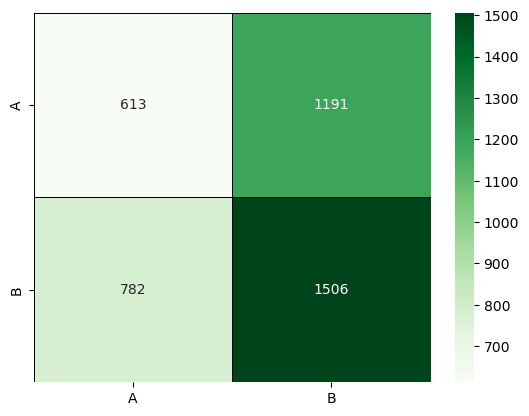

In [71]:
# Adding classes names for better interpretation
classes_names = ['A','B']
cm = pd.DataFrame(confusion_matrix(y_test, classifier_pred), 
                  columns=classes_names, index = classes_names)
                  
# Seaborn's heatmap to better visualize the confusion matrix
sns.heatmap(cm, annot = True, fmt = 'd', cmap='Greens', linewidth =.5, linecolor = 'black');
# Print the balanced_accuracy score of the classifier model
print('\nbalanced accuracy score:', balanced_accuracy_score(y_test, classifier_pred))
# Print the classification report for the model
neo_supp_lend_report = classification_report_imbalanced(y_test, classifier_pred)
print(neo_supp_lend_report) 

# Finding the Best K for KNN Classification
### create a for loop and run models that have from 1 to X neighbors. At each interaction, calculate the f1 and plot the number of Ks along with the f1 result

In [75]:
# create an empty set called 'f1s'
f1s = []

# Calculating f1 score for K values between 1 and 40
for i in range(1, 40):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train_scaled, y_train)
    pred_i = knn.predict(X_test_scaled)
    # using average = 'weighted' to calculate a weighted average for the classes 
    f1s.append(f1_score(y_test, pred_i, average='weighted'))

# plot the f1 values to find the best K

Text(0, 0.5, 'F1 Score')

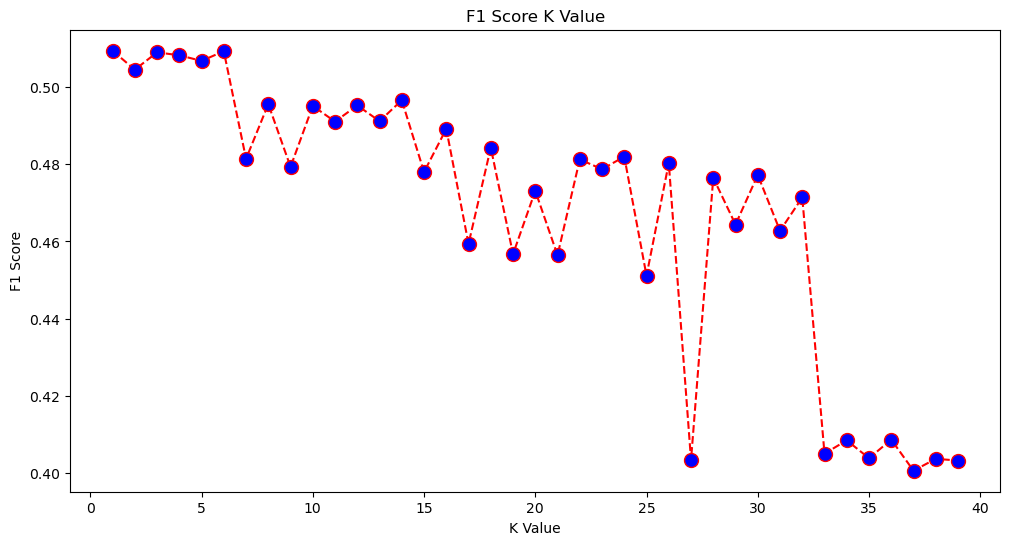

In [76]:
# plot the f1s
plt.figure(figsize=(12, 6))
plt.plot(range(1, 40), f1s, color='red', linestyle='dashed', marker='o',
         markerfacecolor='blue', markersize = 10)
plt.title('F1 Score K Value')
plt.xlabel('K Value')
plt.ylabel('F1 Score')

Text(0, 0.5, 'F1 Score')

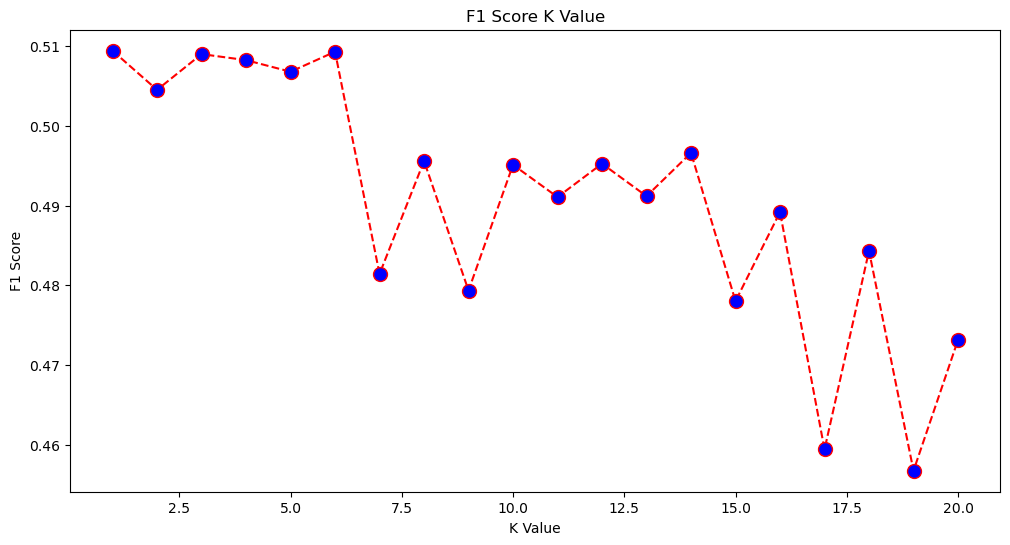

In [77]:
# New f1 plot, less data
plt.figure(figsize=(12, 6))
plt.plot(range(1, 21), f1s[:20], color='red', linestyle='dashed', marker='o',
         markerfacecolor='blue', markersize=10)
plt.title('F1 Score K Value')
plt.xlabel('K Value')
plt.ylabel('F1 Score')

In [78]:
# obtain the highest f1 using the built-in max()
print(max(f1s))                       # 0.5094344985062002
# convert the list into a NumPy array and use argmax() to get highest index of that point
print(np.array(f1s).argmax())         # 1

0.5094344985062002
0


In [83]:
# retrain classifier with 19 neighbors 
classifier1 = KNeighborsClassifier(n_neighbors = 1)
classifier1.fit(X_train_scaled, y_train)
classifier1_pred = classifier1.predict(X_test_scaled)

In [84]:
# Generate a confusion matrix for the classifier19 model
a1_matrix = confusion_matrix(y_test, classifier1_pred)

# Print the confusion matrix for the original test data
print(a1_matrix)

[[ 625 1179]
 [ 786 1502]]


In [85]:
# Adding classes names for better interpretation
classes_names = ['A','B']
cm = pd.DataFrame(a1_matrix(y_test, classifier1_pred), 
                  columns=classes_names, index = classes_names)
                  
# Seaborn's heatmap to better visualize the confusion matrix
sns.heatmap(cm, annot = True, fmt = 'd', cmap='Greens', linewidth =.5, linecolor = 'black');
# Print the balanced_accuracy score of the classifier model
print('\nbalanced accuracy score:', balanced_accuracy_score(y_test, classifier_pred))
# Print the classification report for the model
neo1_supp_lend_report = classification_report_imbalanced(y_test, classifier1_pred)
print(neo1_supp_lend_report) 

TypeError: 'numpy.ndarray' object is not callable